# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2387509369204157736
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13487199871112124645
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Fri Dec 17 16:54:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    33W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [5]:
basemodel = 'ResNet50'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 5
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1", "S2", "S3", "S4"
T_all_labels = "T0", "T1", "T2", "T3", "T4"

#base_path = ''
base_path = 'gdrive/My Drive/Research_5_1_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [6]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_ResNet50_None S_ResNet50_imagenet T_ResNet50_None T_ResNet50_imagenet


['S_ResNet50_imagenet',
 'S_ResNet50_None',
 'T_ResNet50_imagenet',
 'T_ResNet50_None']

In [7]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [8]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [9]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2274, 128, 128, 3) (2274, 1)
(758, 128, 128, 3) (758, 1)
(758, 128, 128, 3) (758, 1)

(2034, 128, 128, 3) (2034, 1)
(678, 128, 128, 3) (678, 1)
(678, 128, 128, 3) (678, 1)


In [10]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [11]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2274, 128, 128, 3) (2274, 5)
(758, 128, 128, 3) (758, 5)
(758, 128, 128, 3) (758, 5)

(2034, 128, 128, 3) (2034, 5)
(678, 128, 128, 3) (678, 5)
(678, 128, 128, 3) (678, 5)


## 2-2. Image Check

xTrain_S image Numbers :  2274
xTrain_S image Numbers // 10 :  227
11


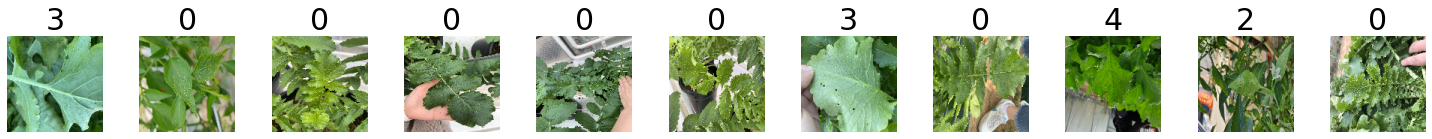

In [12]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  2034
xTrain_S image Numbers // 10 :  203
11


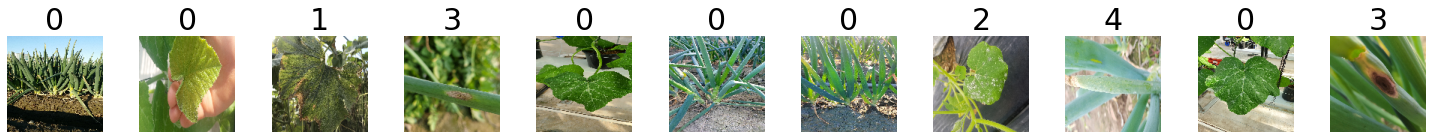

In [13]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [14]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.ResNet50 (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [15]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.ResNet50 (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [17]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [18]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
36/36 [==============================] - 20s 187ms/step - loss: 1.5489 - accuracy: 0.3799 - val_loss: 1.5358 - val_accuracy: 0.2111
Epoch 2/100
36/36 [==============================] - 5s 136ms/step - loss: 1.0946 - accuracy: 0.5519 - val_loss: 1.5294 - val_accuracy: 0.2111
Epoch 3/100
36/36 [==============================] - 5s 135ms/step - loss: 0.8168 - accuracy: 0.6794 - val_loss: 2.1427 - val_accuracy: 0.2111
Epoch 4/100
36/36 [==============================] - 5s 135ms/step - loss: 0.6212 - accuracy: 0.7775 - val_loss: 2.9976 - val_accuracy: 0.2111
Epoch 5/100
36/36 [==============================] - 5s 135ms/step - loss: 0.6079 - accuracy: 0.7735 - val_loss: 3.0479 - val_accuracy: 0.2098
Epoch 6/100
36/36 [==============================] - 5s 136ms/step - loss: 0.5479 - accuracy: 0.7946 - val_loss: 2.4645 - val_accuracy: 0.1227
Epoch 7/100
36/36 [==============================] - 5s 135ms/step - loss: 0.4990 - accuracy: 0.8166 - val_loss: 2.8975 - val_accuracy: 0.188

In [19]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,1.548931,0.379947,1.535772,0.211082
1,1.094594,0.551891,1.529436,0.211082
2,0.816762,0.679420,2.142654,0.211082
3,0.621210,0.777485,2.997567,0.211082
4,0.607923,0.773527,3.047934,0.209763
...,...,...,...,...
95,0.016530,0.995602,1.605171,0.730871
96,0.029884,0.990325,2.758978,0.689974
97,0.029578,0.991645,1.619398,0.711082
98,0.033377,0.988566,2.894602,0.559367


Minimum validation loss: 0.6783246994018555
Maximum validation accuracy: 0.8416886329650879


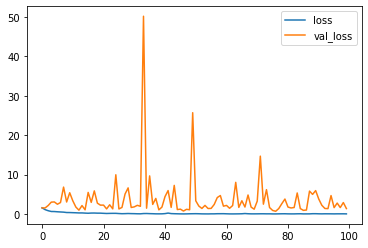

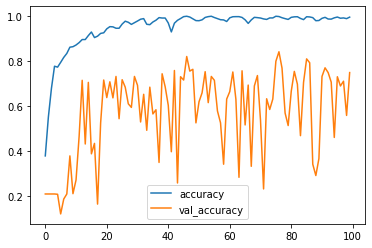

In [20]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [21]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
24/24 [==============================] - 1s 31ms/step - loss: 1.3286 - accuracy: 0.7401
test loss, test acc: [1.3285936117172241, 0.7401055693626404]


In [22]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

24/24 [==============================] - 1s 23ms/step


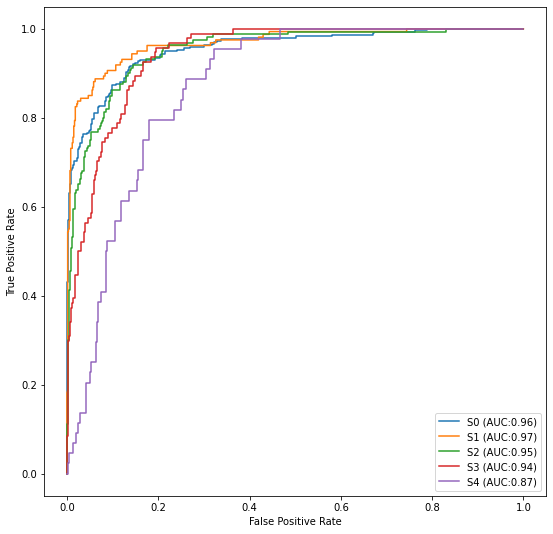

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [24]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

94781440/94765736 [==============================] - 0s 0us/step


In [25]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
36/36 [==============================] - 11s 168ms/step - loss: 0.5531 - accuracy: 0.8171 - val_loss: 11.7137 - val_accuracy: 0.1240
Epoch 2/100
36/36 [==============================] - 5s 138ms/step - loss: 0.3216 - accuracy: 0.8896 - val_loss: 685.8707 - val_accuracy: 0.3958
Epoch 3/100
36/36 [==============================] - 5s 135ms/step - loss: 0.2332 - accuracy: 0.9107 - val_loss: 88.5554 - val_accuracy: 0.3958
Epoch 4/100
36/36 [==============================] - 5s 135ms/step - loss: 0.1881 - accuracy: 0.9327 - val_loss: 14.1664 - val_accuracy: 0.2111
Epoch 5/100
36/36 [==============================] - 5s 135ms/step - loss: 0.1156 - accuracy: 0.9582 - val_loss: 3.3241 - val_accuracy: 0.2111
Epoch 6/100
36/36 [==============================] - 5s 135ms/step - loss: 0.0763 - accuracy: 0.9745 - val_loss: 2.5504 - val_accuracy: 0.2111
Epoch 7/100
36/36 [==============================] - 5s 135ms/step - loss: 0.0769 - accuracy: 0.9657 - val_loss: 1.9380 - val_accuracy: 

In [26]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.553110,0.817062,11.713655,0.124011
1,0.321569,0.889622,685.870667,0.395778
2,0.233163,0.910730,88.555428,0.395778
3,0.188123,0.932718,14.166431,0.211082
4,0.115632,0.958223,3.324100,0.211082
5,0.076271,0.974494,2.550413,0.211082
6,0.076867,0.965699,1.938022,0.204485
7,0.107868,0.963940,6.967746,0.211082
8,0.114847,0.959543,11.600978,0.211082
9,0.082702,0.972735,12.186770,0.211082


Minimum validation loss: 1.9380217790603638
Maximum validation accuracy: 0.3957783579826355


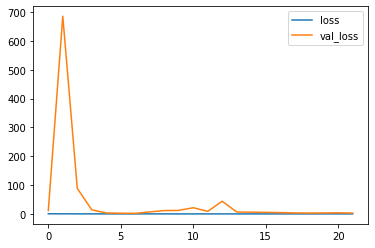

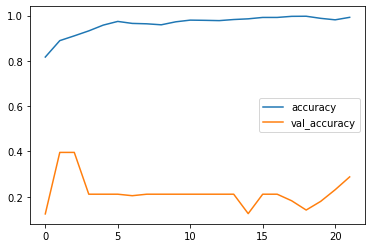

In [27]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [28]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
24/24 [==============================] - 1s 26ms/step - loss: 686.1096 - accuracy: 0.3958
test loss, test acc: [686.1095581054688, 0.3957783579826355]


In [29]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

24/24 [==============================] - 1s 23ms/step


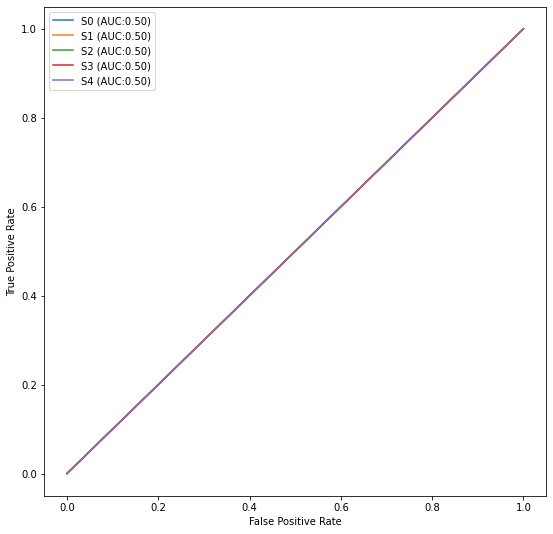

In [30]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [31]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [32]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
32/32 [==============================] - 11s 192ms/step - loss: 1.3205 - accuracy: 0.4946 - val_loss: 2.2190 - val_accuracy: 0.1770
Epoch 2/100
32/32 [==============================] - 4s 136ms/step - loss: 0.7641 - accuracy: 0.7144 - val_loss: 2.4774 - val_accuracy: 0.0649
Epoch 3/100
32/32 [==============================] - 4s 136ms/step - loss: 0.5168 - accuracy: 0.8151 - val_loss: 3.4382 - val_accuracy: 0.0649
Epoch 4/100
32/32 [==============================] - 4s 136ms/step - loss: 0.4063 - accuracy: 0.8515 - val_loss: 4.9001 - val_accuracy: 0.1770
Epoch 5/100
32/32 [==============================] - 4s 138ms/step - loss: 0.3498 - accuracy: 0.8643 - val_loss: 3.9154 - val_accuracy: 0.2021
Epoch 6/100
32/32 [==============================] - 4s 140ms/step - loss: 0.3984 - accuracy: 0.8653 - val_loss: 3.7816 - val_accuracy: 0.2168
Epoch 7/100
32/32 [==============================] - 4s 139ms/step - loss: 0.2787 - accuracy: 0.8933 - val_loss: 3.9598 - val_accuracy: 0.286

In [33]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,1.320458,0.494592,2.218991,0.176991
1,0.764143,0.714356,2.477410,0.064897
2,0.516796,0.815143,3.438239,0.064897
3,0.406266,0.851524,4.900109,0.176991
4,0.349763,0.864307,3.915429,0.202065
...,...,...,...,...
76,0.014833,0.995084,1.267415,0.792035
77,0.008175,0.998525,0.683150,0.858407
78,0.005646,0.998033,0.479214,0.890855
79,0.002529,0.999017,0.202825,0.954277


Minimum validation loss: 0.17011505365371704
Maximum validation accuracy: 0.9646017551422119


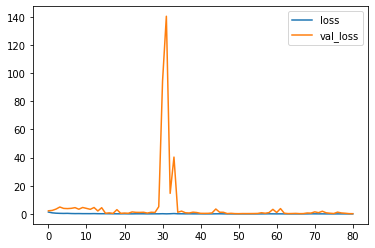

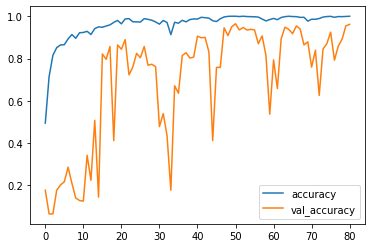

In [34]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [35]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
22/22 [==============================] - 1s 30ms/step - loss: 0.1984 - accuracy: 0.9543
test loss, test acc: [0.19842448830604553, 0.9542772769927979]


In [36]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

22/22 [==============================] - 1s 23ms/step


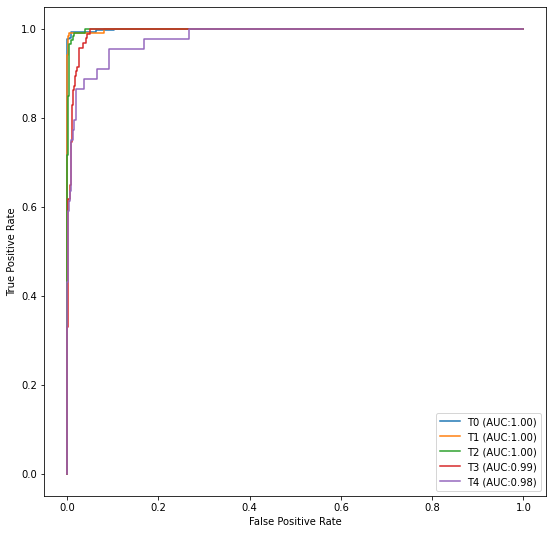

In [37]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [38]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [39]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
32/32 [==============================] - 11s 172ms/step - loss: 0.3904 - accuracy: 0.8574 - val_loss: 597.1434 - val_accuracy: 0.4425
Epoch 2/100
32/32 [==============================] - 4s 136ms/step - loss: 0.2380 - accuracy: 0.9213 - val_loss: 1921.1807 - val_accuracy: 0.4425
Epoch 3/100
32/32 [==============================] - 4s 135ms/step - loss: 0.1554 - accuracy: 0.9454 - val_loss: 1.9155 - val_accuracy: 0.4425
Epoch 4/100
32/32 [==============================] - 4s 136ms/step - loss: 0.0747 - accuracy: 0.9730 - val_loss: 7.3347 - val_accuracy: 0.1386
Epoch 5/100
32/32 [==============================] - 4s 136ms/step - loss: 0.0594 - accuracy: 0.9803 - val_loss: 6.2631 - val_accuracy: 0.0649
Epoch 6/100
32/32 [==============================] - 4s 136ms/step - loss: 0.0877 - accuracy: 0.9813 - val_loss: 4.4217 - val_accuracy: 0.4425
Epoch 7/100
32/32 [==============================] - 4s 136ms/step - loss: 0.0782 - accuracy: 0.9764 - val_loss: 10.2972 - val_accuracy:

In [40]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.390357,0.857424,597.143372,0.442478
1,0.238020,0.921337,1921.180664,0.442478
2,0.155368,0.945428,1.915539,0.442478
3,0.074735,0.972960,7.334687,0.138643
4,0.059364,0.980334,6.263117,0.064897
5,0.087718,0.981318,4.421681,0.442478
6,0.078227,0.976401,10.297205,0.442478
7,0.050472,0.986234,8.839081,0.064897
8,0.041460,0.986234,8.645160,0.064897
9,0.044247,0.989184,4.276953,0.064897


Minimum validation loss: 1.9155385494232178
Maximum validation accuracy: 0.44247788190841675


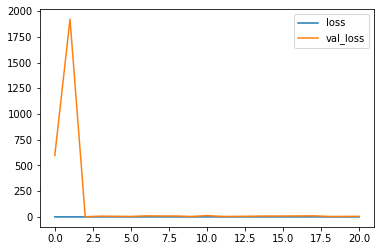

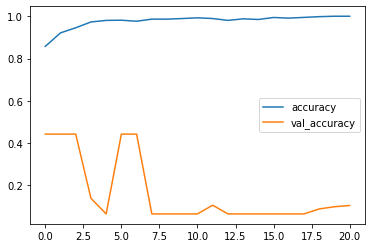

In [41]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [42]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
22/22 [==============================] - 1s 26ms/step - loss: 597.0953 - accuracy: 0.4425
test loss, test acc: [597.0953369140625, 0.44247788190841675]


In [43]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

22/22 [==============================] - 1s 23ms/step


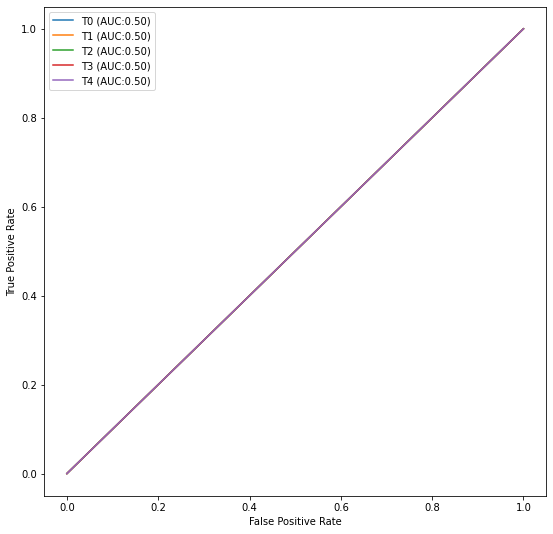

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [45]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_ResNet50_None
test loss, test acc: [1.3285936117172241, 0.7401055693626404]


In [46]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_ResNet50_imagenet
test loss, test acc: [686.1095581054688, 0.3957783579826355]


In [47]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_ResNet50_None
test loss, test acc: [0.19842448830604553, 0.9542772769927979]


In [48]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_ResNet50_imagenet
test loss, test acc: [597.0953369140625, 0.44247788190841675]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [49]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_ResNet50_None →→→ Target Test
22/22 [==============================] - 1s 26ms/step - loss: 6.9818 - accuracy: 0.2965
test loss, test acc: [6.9817657470703125, 0.29646018147468567]


In [50]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_ResNet50_imagenet →→→ Target Test
22/22 [==============================] - 1s 25ms/step - loss: 647.0571 - accuracy: 0.4425
test loss, test acc: [647.0570678710938, 0.44247788190841675]


In [51]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_ResNet50_None →→→ Source Test
24/24 [==============================] - 1s 26ms/step - loss: 4.6744 - accuracy: 0.2665
test loss, test acc: [4.674370765686035, 0.26649075746536255]


In [52]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_ResNet50_imagenet →→→ Source Test
24/24 [==============================] - 1s 26ms/step - loss: 623.4297 - accuracy: 0.3958
test loss, test acc: [623.4297485351562, 0.3957783579826355]


# 6. Model Save 

In [53]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
